# BLIP vs CLIP Comparison

## Quick Rundown
- CLIP is a multi-modal language model trained on parings between text and images to learn a joint representation of the two modalities. This allows for direct comparison between images and text using similarity metrics like cosine similarity. However, this narrowly defined objective prevents CLIP from being used as a standalone reasoning model.
    - Flamingo is a more generally capable model that builds directly off of CLIP, sharing a hidden dimension of 1024. It can account for arbitrary length sequences with its perceiver architecture, which maintains the arbitrary length input for the purposes of cross attention with a fixed-size latent bottleneck; a fixed number of repeats of alternating cross attention and self attention layers are used to "copy" all of the relevant from the input into the latent space which goes on to be processed by the rest of the model.
- BLIP-2 is a multi-modal language model with more general capabilities than CLIP, but which does not learn a joint representation of text and images. Instead, it uses a querying transformer, which is composed of two transformer blocks. One block takes learned queries as input and cross-attends with the output of a frozen (and swappable) image encoder, while the other is a simple text transformer. Essentially, what this does is map from a pre-existing semantic space for images and a pre-existing semantic space for text into a learned internal representation trained to extract the information from the image most relevant to the text. This internal representation is then passed to the model's decoder. This architecture is highly modular as the image encoder, text encoder, and general decoder can all be swapped out for different models.
    - In the 3D-LLM paper, they opt to use the T5 text encoder due to its greater representational ability, and an expanded CLIP image encoder (EVA_CLIP) with a larger feature dimension and a special positional encoding to represent the 3d space in which the points live. The positional encoding is left unfrozen during fine-tuning to allow the model to learn spatial reasoning.
    - The querying transformer architecture also allows BLIP-2 to handle arbitrarily sized multimodal inputs.
- Flamingo is a multi-modal language model that preceded BLIP-2 

## Section 1: Question answering
The images below are captured directly from Mujoco, the simulator used by the RoCo paper. The use of that simulator allows me to bypass the doing image segmentation and point cloud reconstruction myself, which saves crucial compute resources; the simulator has built in methods to segment 2d camera renders by objects specified by tags in the xml file, which makes getting object specific pictures and determing which point cloud points correspond to what object trivial. I use BLIP-2 to make the captions.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import gc
plt.clf()
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']

<Figure size 640x480 with 0 Axes>

In [2]:
# BLIP captioning
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoProcessor
import torch

class Blip2:
    def __init__(self, device_id):
        self.device = "cuda:{}".format(device_id)

        self.blip2_processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
        self.blip2 = Blip2ForConditionalGeneration.from_pretrained(
            "Salesforce/blip2-flan-t5-xl", device_map={"": device_id}, torch_dtype=torch.float16
        )

    def ask(self, raw_image, question):
        inputs = self.blip2_processor(raw_image, question, return_tensors="pt").to(self.device, torch.float16)
        out = self.blip2.generate(**inputs)
        answer = self.blip2_processor.decode(out[0], skip_special_tokens=True)
        return answer
    
    def nucleus_ask(self, raw_image, question):
        inputs = self.blip2_processor(raw_image, question, return_tensors="pt").to(self.device, torch.float16)
        # print(self.blip2)
        print(inputs)
        generated_ids = self.blip2.generate(
            **inputs,
            # pixel_values=inputs.pixel_values,
            do_sample="Nucleus sampling",
            temperature=0.5,
            length_penalty=-1.0,
            repetition_penalty=1.0,
            max_length=30,
            min_length=1,
            num_beams=5,
            top_p=0.1
        )
        print(generated_ids)
        result = self.blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return result

    def caption(self, raw_image, mode="default"):
        if mode == "default":
            # starndard way to caption an image in the blip2 paper
            caption = self.ask(raw_image, "a photo of")
            caption = caption.replace("\n", " ").strip()  # trim caption
        elif mode == "nucleus":
            caption = self.nucleus_ask(raw_image, "a photo of")
        return caption
    
blip2_inst = Blip2(0)

blip_captions = {cam_name: blip2_inst.caption(outputs[cam_name]) for cam_name in point_feature_cameras}

# Clean up
blip2_inst = None
del blip2_inst
gc.collect()

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


21

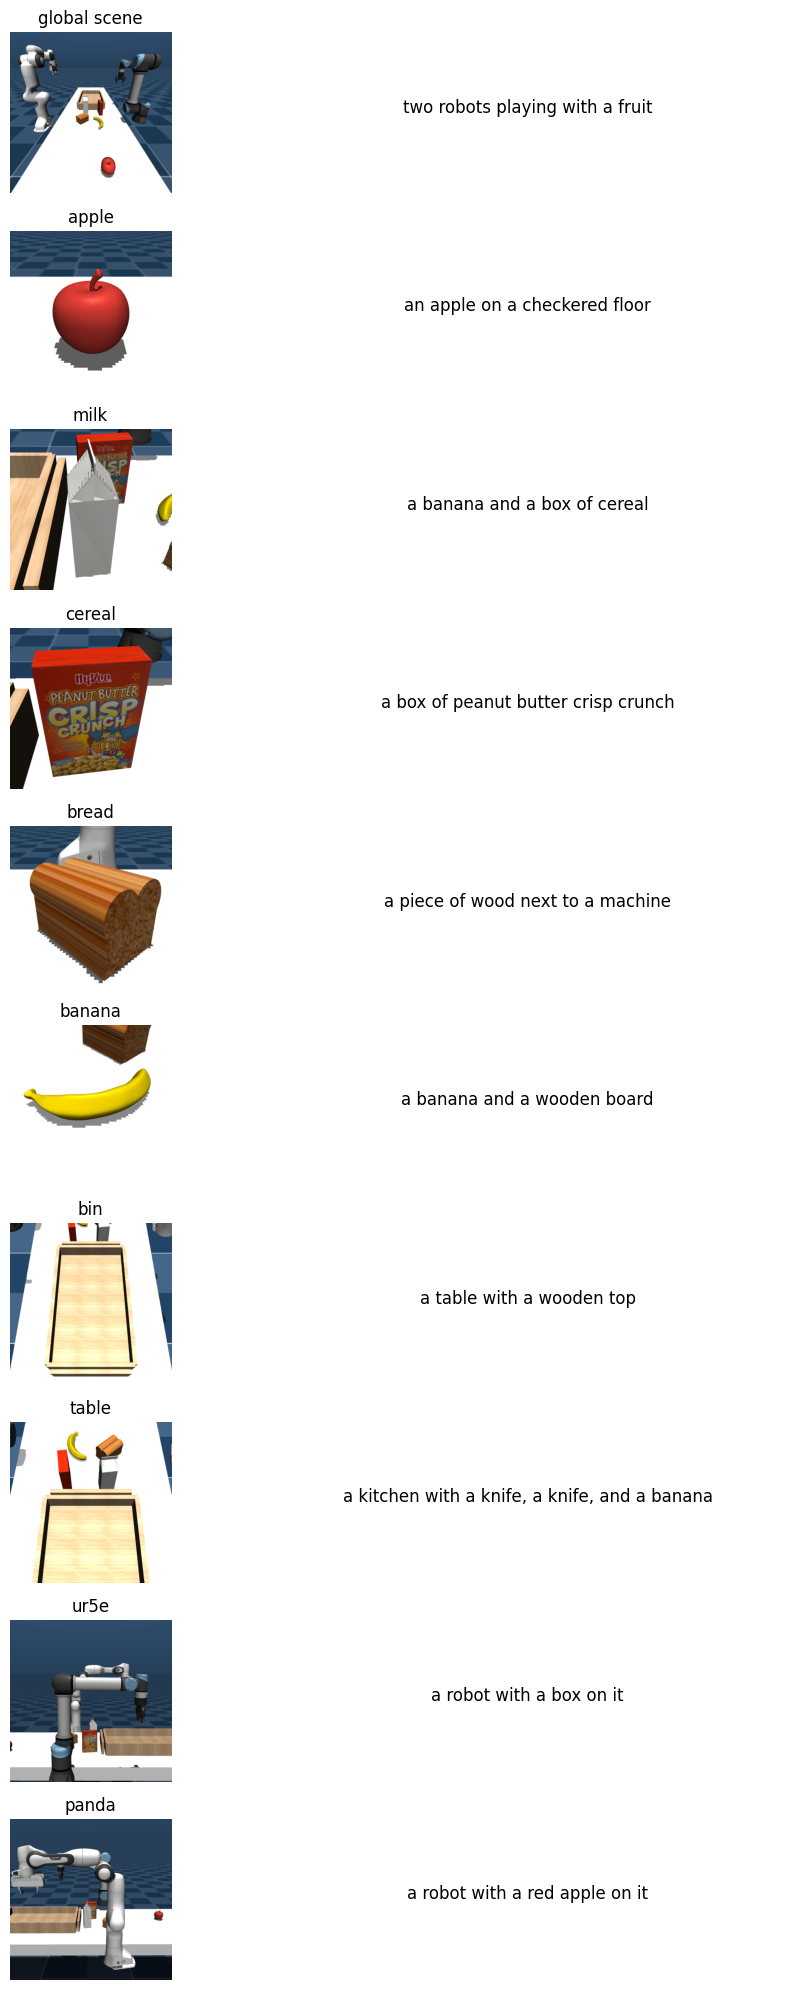

In [4]:
fig, ax = plt.subplots(10,2, figsize=(10, 20))

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']
for i, point_feature_camera in enumerate(point_feature_cameras):
    ax[i,0].imshow(outputs[point_feature_camera])
    ax[i,0].set_title(point_feature_camera if point_feature_camera != 'sceneshotcam' else 'global scene')
    ax[i,0].axis('off')
    ax[i,1].text(0.5, 0.5, blip_captions[point_feature_camera], fontsize=12, ha='center')
    ax[i,1].axis('off')
plt.tight_layout()
plt.show()

## Section 2: Semantic Search in a point cloud
The main aim of this project is to take the images above and provide them to the model in the form of a point cloud of feature vectors. The model will then be able to reason about the objects present spatially. While the only weights provided are for the BLIP-2 model, the fact that CLIP has a joint representation of text and images allows for a visualization of what is going on behind the scenes. In this demonstration, searching for a word will cause the part of the point cloud where that object is light up.

In [7]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.set_grad_enabled(False)
from lavis.common.registry import registry
from omegaconf import OmegaConf
from tqdm import tqdm
import cv2
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

- Load the CLIP model

In [8]:
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
model.cuda()
model.eval()
tokenizer = open_clip.get_tokenizer("ViT-H-14")

- Create a global scene vector from the global scene image

In [9]:
global_feat = None
scene_img = outputs["sceneshotcam"]
scene_img = cv2.resize(scene_img, (512, 512))
with torch.cuda.amp.autocast():
    _img = preprocess(Image.fromarray(scene_img)).unsqueeze(0)
    imgfeat = model.encode_image(_img.cuda())  # [1, 1024]

global_feat = imgfeat.half().cuda()

global_feat = torch.nn.functional.normalize(global_feat, dim=-1)  # --> (1, 1024)
FEAT_DIM = global_feat.shape[-1]

- Calculate the per-object features

In [10]:
cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    obj_img = outputs[view]
    roi = torch.ones((512, 512, 3))
    img_roi = torch.tensor(obj_img[:512,:512])
    roi[:img_roi.shape[0], :img_roi.shape[1]] = img_roi
    roi = roi.detach().cpu().numpy()
    img_roi = Image.fromarray(roi.astype('uint8'))
    img_roi = preprocess(img_roi).unsqueeze(0).cuda()
    roifeat = model.encode_image(img_roi).half().cuda()
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

100%|██████████| 9/9 [00:00<00:00, 13.52it/s]


- Compute the inter-object similarity to determine the relevance of each

In [11]:
scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
print(specific_views)
print(mask_sim_mat)
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores
print(softmax_scores)

['panda', 'apple', 'table', 'ur5e', 'bin', 'milk', 'cereal', 'bread', 'banana']
tensor([[1.0000, 0.6626, 0.6738, 0.9385, 0.6562, 0.5918, 0.5176, 0.5542, 0.5801],
        [0.6626, 0.9995, 0.6240, 0.6367, 0.5522, 0.6064, 0.5483, 0.5581, 0.6807],
        [0.6738, 0.6240, 1.0010, 0.6743, 0.8242, 0.7310, 0.5439, 0.5596, 0.7148],
        [0.9385, 0.6367, 0.6743, 1.0000, 0.6543, 0.6367, 0.5562, 0.5522, 0.6040],
        [0.6562, 0.5522, 0.8242, 0.6543, 1.0000, 0.6841, 0.5054, 0.6094, 0.6069],
        [0.5918, 0.6064, 0.7310, 0.6367, 0.6841, 1.0000, 0.6626, 0.5742, 0.6650],
        [0.5176, 0.5483, 0.5439, 0.5562, 0.5054, 0.6626, 1.0000, 0.4668, 0.5869],
        [0.5542, 0.5581, 0.5596, 0.5522, 0.6094, 0.5742, 0.4668, 1.0000, 0.6113],
        [0.5801, 0.6807, 0.7148, 0.6040, 0.6069, 0.6650, 0.5869, 0.6113, 1.0010]],
       device='cuda:0', dtype=torch.float16)
tensor([0.1317, 0.1121, 0.1157, 0.1263, 0.1097, 0.1017, 0.1018, 0.1010, 0.1001],
       device='cuda:0', dtype=torch.float16)


- Obtain the pixel-aligned features

In [12]:
xyz_pts = outputs['xyz_pts']
segmentation_pts = outputs['segmentation_pts']
rgb_pts = outputs['rgb_pts']
pixelwise_features = global_feat.repeat((xyz_pts.shape[0], 1))

pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[segmentation_pts[specific_views[objidx]], :] = _weighted_feat.half()

- Compute the similarity between the points in the point cloud and the search text

In [13]:
text = tokenizer([input()])
textfeat = model.encode_text(text.cuda())
textfeat = torch.nn.functional.normalize(textfeat, dim=-1)
textfeat = textfeat.unsqueeze(0)

map_embeddings_norm = torch.nn.functional.normalize(pixelwise_features, dim=1)
cosine_similarity = torch.nn.CosineSimilarity(dim=-1).to('cuda')

# calculate the similarity between all of the pixel-level embeddings and the prompt, and scale it to the [0,1] range (normally [-1,1]) to serve as a colormap weight
similarity = cosine_similarity(
    map_embeddings_norm, textfeat
)

similarity_shifted = (similarity + 1.0) / 2.0 # shift the similarity to the [0,1] range

similarity_rel = (similarity_shifted - similarity_shifted.min()) / (
                similarity_shifted.max() - similarity_shifted.min() + 1e-12
            ) # normalize the similarity to the [0,1] range

similarity_rel_thresholded = similarity_rel.clone()
similarity_rel_thresholded[similarity_rel_thresholded < 0.6] = 0.0

- Display the color map

/var/tmp/ipykernel_6639/2002486168.py:21: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_6639/2002486168.py:22: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_6639/2002486168.py:23: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore


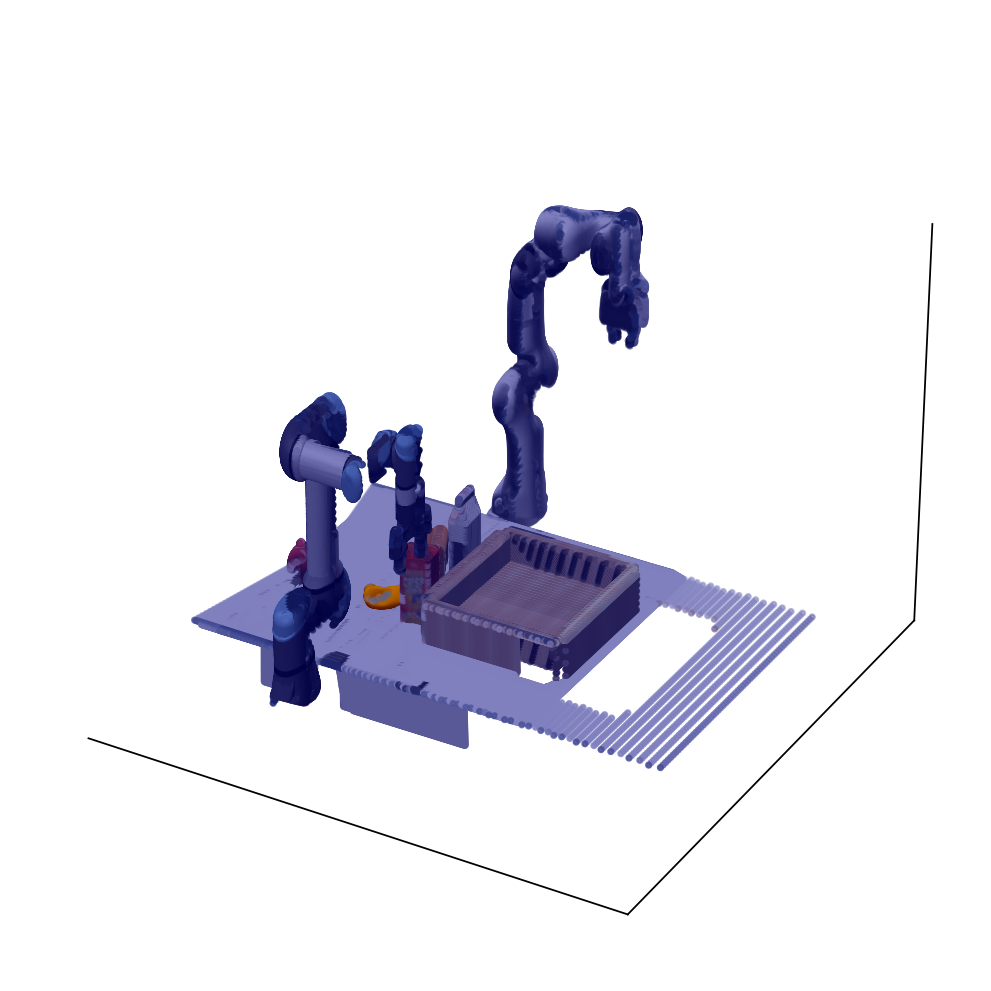

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")

x, y, z = (
    xyz_pts[:, 0],
    xyz_pts[:, 1],
    xyz_pts[:, 2],
)

cmap = colormaps.get_cmap('jet')
similarity_colormap = cmap(similarity_rel_thresholded[0].detach().cpu().numpy())[:, :3]

rgb_pts = outputs['rgb_pts'].astype(float)/255.0
plot_colors = rgb_pts * 0.5 + similarity_colormap * 0.5

ax.set_facecolor((1.0, 1.0, 1.0))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore

ax.scatter(
    x,
    y,
    z,
    c=plot_colors,
    s=5,  # type: ignore
)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])  # type: ignore

plt.tight_layout(pad=0)
plt.show()
plt.close(fig)